<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/2_1_3_1_Lab_Coffee_Roasting_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Coffee Roasting in Tensor Flow

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Dataset

In [2]:
# Temperature (Celsius), Duration (minutes)
X = np.array([[185.32,  12.69],
       [259.92,  11.87],
       [231.01,  14.41],
       [175.37,  11.72],
       [187.12,  14.13],
       [225.91,  12.1 ],
       [208.41,  14.18],
       [207.08,  14.03],
       [280.6 ,  14.23],
       [202.87,  12.25],
       [196.7 ,  13.54],
       [270.31,  14.6 ],
       [192.95,  15.2 ],
       [213.57,  14.28],
       [164.47,  11.92],
       [177.26,  15.04],
       [241.77,  14.9 ],
       [237.  ,  13.13],
       [219.74,  13.87],
       [266.39,  13.25],
       [270.45,  13.95],
       [261.96,  13.49],
       [243.49,  12.86],
       [220.58,  12.36],
       [163.59,  11.65],
       [244.76,  13.33],
       [271.19,  14.84],
       [201.99,  15.39],
       [229.93,  14.56],
       [204.97,  12.28],
       [173.19,  12.22],
       [231.51,  11.95],
       [152.69,  14.83],
       [163.42,  13.3 ],
       [215.95,  13.98],
       [218.04,  15.25],
       [251.3 ,  13.8 ],
       [233.33,  13.53],
       [280.24,  12.41],
       [243.02,  13.72],
       [155.67,  12.68],
       [275.17,  14.64],
       [151.73,  12.69],
       [151.32,  14.81],
       [164.9 ,  11.73],
       [282.55,  13.28],
       [192.98,  11.7 ],
       [202.6 ,  12.96],
       [220.67,  11.53],
       [169.97,  12.34],
       [209.47,  12.71],
       [232.8 ,  12.64],
       [272.8 ,  15.35],
       [158.02,  12.34],
       [226.01,  14.58],
       [158.64,  12.24],
       [211.66,  14.17],
       [271.95,  14.97],
       [257.16,  11.71],
       [281.85,  13.96],
       [161.63,  12.52],
       [233.8 ,  13.04],
       [210.29,  14.72],
       [261.24,  13.69],
       [256.98,  13.12],
       [281.56,  13.92],
       [280.64,  11.68],
       [269.16,  13.74],
       [246.34,  12.27],
       [224.07,  12.66],
       [164.24,  11.51],
       [272.42,  14.18],
       [177.68,  12.53],
       [212.86,  14.77],
       [165.88,  15.37],
       [277.43,  12.48],
       [236.51,  12.94],
       [244.14,  11.85],
       [213.45,  13.85],
       [234.57,  14.27],
       [270.34,  12.47],
       [170.68,  13.06],
       [226.79,  15.34],
       [245.92,  14.45],
       [281.32,  12.57],
       [185.03,  13.19],
       [189.88,  14.1 ],
       [278.48,  12.11],
       [219.92,  14.21],
       [216.58,  15.15],
       [249.48,  15.03],
       [165.09,  12.28],
       [158.87,  14.82],
       [279.98,  11.56],
       [256.55,  14.41],
       [272.61,  12.58],
       [246.49,  12.45],
       [160.26,  14.48],
       [155.7 ,  14.3 ],
       [188.27,  13.45],
       [270.36,  12.47],
       [213.22,  12.92],
       [175.7 ,  13.39],
       [174.52,  14.7 ],
       [233.  ,  12.63],
       [281.37,  12.88],
       [240.62,  14.43],
       [185.81,  11.55],
       [270.5 ,  15.33],
       [172.98,  12.11],
       [208.41,  13.89],
       [283.51,  15.35],
       [283.36,  12.48],
       [230.85,  13.24],
       [181.24,  11.76],
       [172.78,  12.93],
       [161.88,  12.1 ],
       [156.03,  13.99],
       [216.52,  12.47],
       [221.06,  13.2 ],
       [238.99,  15.23],
       [197.69,  14.08],
       [179.55,  15.26],
       [233.39,  12.13],
       [184.7 ,  12.14],
       [174.18,  12.73],
       [261.11,  13.33],
       [187.42,  13.18],
       [186.1 ,  14.43],
       [157.94,  12.66],
       [193.64,  12.23],
       [249.65,  12.22],
       [190.56,  11.73],
       [252.  ,  12.96],
       [238.55,  12.37],
       [152.94,  12.79],
       [255.17,  14.85],
       [197.09,  14.89],
       [156.8 ,  13.59],
       [184.75,  13.26],
       [179.92,  15.07],
       [190.79,  15.28],
       [164.73,  13.22],
       [209.87,  14.34],
       [196.58,  13.47],
       [159.51,  12.74],
       [247.87,  11.92],
       [212.44,  12.45],
       [172.34,  11.99],
       [259.87,  14.25],
       [201.23,  13.07],
       [248.34,  13.92],
       [273.66,  15.18],
       [215.09,  14.14],
       [223.53,  12.74],
       [211.22,  14.38],
       [224.61,  14.03],
       [215.75,  15.31],
       [254.82,  12.02],
       [259.9 ,  15.17],
       [260.25,  12.87],
       [199.67,  12.47],
       [157.52,  13.39],
       [264.81,  14.58],
       [239.4 ,  14.89],
       [238.98,  12.39],
       [258.43,  12.97],
       [270.16,  12.81],
       [162.41,  14.42],
       [164.53,  14.98],
       [205.61,  14.62],
       [157.1 ,  13.68],
       [241.38,  12.02],
       [232.13,  12.07],
       [191.04,  12.96],
       [233.64,  12.02],
       [174.95,  14.63],
       [246.64,  13.32],
       [188.07,  14.27],
       [213.16,  12.75],
       [268.08,  12.31],
       [258.58,  13.97],
       [237.21,  14.23],
       [251.02,  15.02],
       [274.28,  12.52],
       [172.12,  15.09],
       [177.52,  12.39],
       [258.71,  15.36],
       [264.01,  13.57],
       [200.71,  15.45],
       [249.37,  14.02],
       [151.5 ,  12.28],
       [151.82,  15.13],
       [181.92,  12.18],
       [228.65,  12.31],
       [223.78,  15.3 ],
       [266.63,  12.48],
       [273.68,  13.1 ],
       [220.61,  12.8 ],
       [284.99,  12.73]])

In [3]:
Y = np.array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [4]:
X.shape, Y.shape

((200, 2), (200, 1))

## Plot Coffee Roasting Data

In [5]:
X[Y.reshape(-1,) == 1, 0]

array([185.32, 187.12, 225.91, 202.87, 196.7 , 220.58, 204.97, 202.6 ,
       209.47, 232.8 , 246.34, 224.07, 177.68, 185.03, 189.88, 188.27,
       213.22, 175.7 , 233.  , 216.52, 221.06, 233.39, 184.7 , 187.42,
       193.64, 238.55, 184.75, 196.58, 212.44, 201.23, 223.53, 199.67,
       238.98, 241.38, 232.13, 191.04, 233.64, 188.07, 213.16, 177.52,
       181.92, 228.65, 220.61])

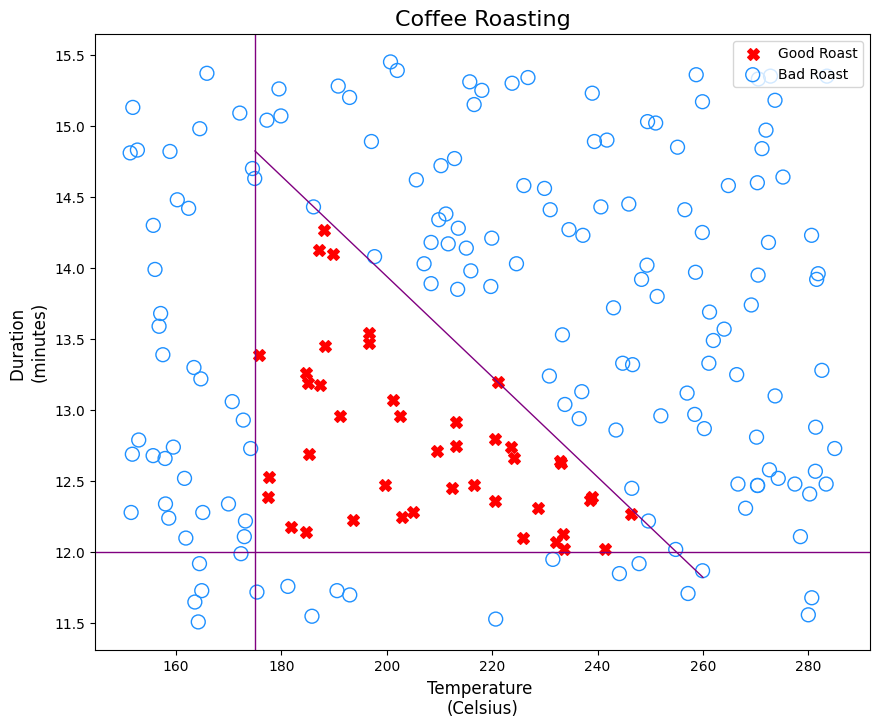

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

y = Y.reshape(-1, )
# temperature on x-axis, duration on y-axis
ax.scatter(X[y==1, 0], X[y==1, 1], s=70, marker='X', c='r', label='Good Roast')
ax.scatter(X[y==0, 0], X[y==0, 1], s=100, marker='o', facecolor='none',
           edgecolors='dodgerblue', linewidth=1, label='Bad Roast')
ax.axhline(y=12, color='purple', linewidth=1)
ax.axvline(x=175, color='purple', linewidth=1)
tr = np.linspace(175, 260, 50)
ax.plot(tr, (-3/85) * tr + 21, color='purple', linewidth=1)

ax.set_title('Coffee Roasting', size=16)
ax.set_xlabel("Temperature \n(Celsius)",size=12)
ax.set_ylabel("Duration \n(minutes)",size=12)
ax.legend(loc='upper right')

plt.show()

## Normalize Data

- Fitting the weights to the data (back-propagation) proceeds more quickly when the data is normalize
- This procedure uses the Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
- Steps
 1. Create a "Normalization Layer": this is not a layer in your model
 2. `adapt` the data (learns the mean and variance of the dataset and stores the values internally
 2. normalize the data

In [7]:
# max and min temperature
np.max(X[:, 0]), np.min(X[:, 0])

(284.99, 151.32)

In [8]:
# max and min duration
np.max(X[:, 1]), np.min(X[:, 1])

(15.45, 11.51)

In [9]:
norm_1 = tf.keras.layers.Normalization(axis=-1)
norm_1.adapt(X)
Xn = norm_1(X)

In [10]:
# max and min temperature
np.max(Xn[:, 0]), np.min(Xn[:, 0])

(1.6596596, -1.6853083)

In [11]:
# max and min duration
np.max(Xn[:, 1]), np.min(Xn[:, 1])

(1.7897574, -1.7021072)

## Tile Data

In [12]:
# tile/copy data to increase the training set size and
#  reduce the number of epochs
Xt = np.tile(Xn, (1000, 1))
Yt = np.tile(Y, (1000, 1))

In [13]:
X.shape, Xn.shape, Xt.shape

((200, 2), TensorShape([200, 2]), (200000, 2))

In [14]:
Y.shape, Yt.shape

((200, 1), (200000, 1))

In [15]:
Xn[0:5, :], Xt[0:5, :], Xt[200:205]

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[-0.83448976, -0.6563208 ],
        [ 1.0323066 , -1.3830538 ],
        [ 0.30886003,  0.8680468 ],
        [-1.0834796 , -1.5159925 ],
        [-0.7894467 ,  0.6198942 ]], dtype=float32)>,
 array([[-0.83448976, -0.6563208 ],
        [ 1.0323066 , -1.3830538 ],
        [ 0.30886003,  0.8680468 ],
        [-1.0834796 , -1.5159925 ],
        [-0.7894467 ,  0.6198942 ]], dtype=float32),
 array([[-0.83448976, -0.6563208 ],
        [ 1.0323066 , -1.3830538 ],
        [ 0.30886003,  0.8680468 ],
        [-1.0834796 , -1.5159925 ],
        [-0.7894467 ,  0.6198942 ]], dtype=float32))

In [16]:
Y[0:5], Yt[0:5], Yt[200:205], Yt[400:405]

(array([[1.],
        [0.],
        [0.],
        [0.],
        [1.]]),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [1.]]),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [1.]]),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [1.]]))

## TensorFlow Model

<img src='https://drive.google.com/uc?export=view&id=1pNscrM4uMbFa1Lvhqv6YyNC-Ivy2i5hh'>



In [17]:
tf.random.set_seed(1234)

model = Sequential([
    tf.keras.Input(shape=(2, )),
    Dense(3, activation='sigmoid', name='layer1'),
    Dense(1, activation='sigmoid', name='layer2')
])

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
layer1 = model.get_layer('layer1')
layer2 = model.get_layer('layer2')

In [20]:
# number of variables in input * number nodes + number nodes
L1_num_params = layer1.input.shape[1] * layer1.units + layer1.units # W1 parameters + b_parameters
L2_num_params = layer2.input.shape[1] * layer2.units + layer2.units
L1_num_params, L2_num_params

(9, 4)

## Initial Weights

In [21]:
W1, b1 = layer1.get_weights()
W1, b1

(array([[-0.43748373, -0.69526917, -0.5482541 ],
        [-0.6390673 ,  0.40119636, -0.213507  ]], dtype=float32),
 array([0., 0., 0.], dtype=float32))

In [22]:
W2, b2 = layer2.get_weights()
W2, b2

(array([[-0.38817453],
        [-0.95930314],
        [-0.08866107]], dtype=float32),
 array([0.], dtype=float32))

The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.BinaryCrossentropy()
)

In [24]:
model.fit(Xt, Yt, epochs=10)

Epoch 1/10
6250/6250 [==============================] - 23s 3ms/step - loss: 0.2759
Epoch 2/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1362
Epoch 3/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.1302
Epoch 4/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.1227
Epoch 5/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.1152
Epoch 6/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.1092
Epoch 7/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0548
Epoch 8/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0139
Epoch 9/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0091
Epoch 10/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0065


## Epochs and batches

In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.1839
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

## Updated weights

In [25]:
W1, b1 = layer1.get_weights()
W1, b1

(array([[13.72331   , -9.827587  ,  0.13677995],
        [11.424054  , -0.1998485 , -8.21591   ]], dtype=float32),
 array([  1.3569852, -10.765054 , -10.374317 ], dtype=float32))

In [26]:
W2, b2 = layer2.get_weights()
W2, b2

(array([[-33.79269 ],
        [-35.184044],
        [-30.496597]], dtype=float32),
 array([17.774477], dtype=float32))

## Predictions

In [27]:
predictions = model.predict(Xn)
predictions # these are probabilities

7/7 [==============================] - 0s 2ms/step


array([[9.99999583e-01],
       [2.39141351e-09],
       [1.10501546e-07],
       [6.32899495e-13],
       [9.99998569e-01],
       [9.99382377e-01],
       [1.27170992e-07],
       [3.09934023e-07],
       [1.10503656e-07],
       [9.99998689e-01],
       [1.00000000e+00],
       [1.10504075e-07],
       [8.18919261e-08],
       [1.11277345e-07],
       [1.72319133e-15],
       [9.58138863e-12],
       [1.10503656e-07],
       [1.52796545e-07],
       [1.18473096e-07],
       [1.10044297e-07],
       [1.10501126e-07],
       [1.10425276e-07],
       [1.79019253e-07],
       [9.99999821e-01],
       [9.03026612e-20],
       [1.10606138e-07],
       [1.10504075e-07],
       [1.07055207e-07],
       [1.10499862e-07],
       [9.99999344e-01],
       [5.22262635e-05],
       [2.98893720e-01],
       [3.23728138e-08],
       [1.89597699e-07],
       [1.20107188e-07],
       [1.10434549e-07],
       [1.10496487e-07],
       [1.12754094e-07],
       [1.71570367e-08],
       [1.10502391e-07],


In [28]:
y_hat = (predictions >= 0.5).astype(int)
y_hat

array([[1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [29]:
sum(y_hat == Y) / len(Y) # 100% accuracy

array([1.])

## Layer Functions

Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.